In [ ]:
!pip install torch torchvision timm numpy matplotlib tqdm scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import urllib.request
import tarfile
import numpy as np
import torch
import torch.nn as nn
import timm
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader , random_split
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import time

Predicted class: [ 70  62 190 464 180 165 284  62  16 180 130  16 410  17  45 512 414 146
  92 386  16  16  47 124 190 410 356  19  16 298 122 120  16  16 414 174
 106 190 140 216 390 145  12  16 193 175 414 213 160  76 213 178 410 165
 188 538  16 190  16 316 107  46 165 193 193  76 164 105 120 176 159  89
  16 139  98 410 330 353 386  32  16  45  17  92 390  16  62 172 189  16
  16 414  64 414  16  18 464  91  17 121 376  19 414  88  17 213 191 156
 387 410 414  18 414 165 160 181 303 410  16 410 303 482  89  75 333 342
 303 229  16 136 217  16 105 141 414 411 410 414 120 333 303 410 165  18
 483 230 229 193  92 410  20 213 414 150  92 135 179  45 449 436  82 414
   5  92  62 100 166 129  16  18  76 399 179 179 284 162  82 112  98 110
  48 414 160  20  46 160 510 150 410 522 106 193  16 166 136 414 106 144
 100  16]


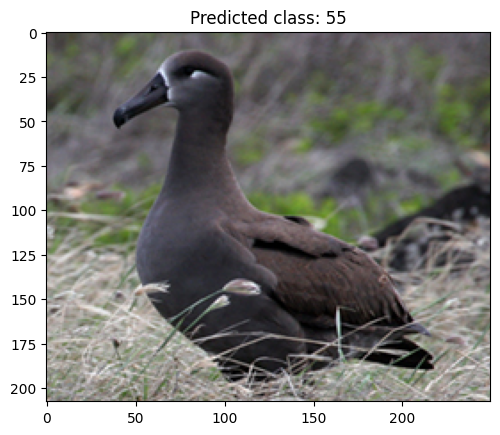

In [ ]:
from PIL import Image

class ViTAttention(nn.Module):
    def __init__(self, in_channels, num_classes, pretrained=True):
        super(ViTAttention, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=False)

        if pretrained:
            self.model.load_state_dict(torch.load('/content/drive/MyDrive/fine_grained_image_classification/pytorch_model.bin'))


        # Modify the last layer for fine-grained classification
        num_features = self.model.head.in_features
        self.model.head = nn.Linear(num_features, num_classes)

        # Add attention mechanisms
        self.attention1 = SelfAttention(num_features)
        self.attention2 = HierarchicalAttention(num_features)

    def forward(self, x):
        features = self.model.forward_features(x)

        # Apply attention mechanisms
        attention1 = self.attention1(features)
        attention2 = self.attention2(features)

        # Concatenate attention features
        features = torch.cat((features, attention1, attention2), dim=1)

        # Pass through the final classifier
        output = self.model.head(features)

        return output

class SelfAttention(nn.Module):
    def __init__(self, num_features):
        super(SelfAttention, self).__init__()
        self.num_features = num_features
        self.query = nn.Linear(num_features, num_features)
        self.key = nn.Linear(num_features, num_features)
        self.value = nn.Linear(num_features, num_features)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, features):
        queries = self.query(features)
        keys = self.key(features)
        values = self.value(features)

        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        attention_scores = attention_scores / (self.num_features ** 0.5)
        attention_weights = self.softmax(attention_scores)

        attention_output = torch.matmul(attention_weights, values)

        return attention_output

class HierarchicalAttention(nn.Module):
    def __init__(self, num_features):
        super(HierarchicalAttention, self).__init__()
        self.attention1 = SelfAttention(num_features)
        self.attention2 = SelfAttention(num_features)

    def forward(self, features):
        attention1 = self.attention1(features)
        attention2 = self.attention2(attention1)

        return attention2

# Load the model
model_path = '/content/drive/MyDrive/fine_grained_image_classification/model_epoch_20.pth'
# model = ViTAttention(in_channels=3, num_classes=200, pretrained=True)
# # model.load_state_dict(torch.load(model_path))
# # model.eval()


# Load the model
model = ViTAttention(in_channels=3, num_classes=200, pretrained=True)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.eval()

# Function to preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to the size expected by the model
        transforms.ToTensor(),         # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
    ])
    image = preprocess(image).unsqueeze(0)  # Add batch dimension
    return image

import numpy as np

def predict(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    return predicted.numpy()[0]  # Get the predicted class index as a scalar





# Path to the image
image_path = '/content/drive/MyDrive/fine_grained_image_classification/Black_Footed_Albatross_0025_796057.jpg'

# Make prediction
predicted_class = predict(image_path)

max_value = np.max(predicted_class)

# Find the index of the maximum element using np.argmax
max_index = np.argmax(predicted_class)

print(f'Predicted class: {predicted_class}')

# Display the image
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Predicted class: {max_index}')
plt.show()